In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc

In [2]:
sns.set_context('talk')

In [3]:
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')

In [11]:
import skimage.io as io

In [13]:
from skimage.color import rgb2gray

In [4]:
DEBUG = True

# HOG computer

In [69]:
def compute_integral_hist(values, bin_count, limits, weights):
    diff_hist = np.zeros(values.shape + (bin_count, ))
    integral_hist = np.zeros(values.shape + (bin_count, ))
    values = (values - limits[0]) / (limits[1] - limits[0]) * bin_count
    for first in range(values.shape[0]):
        for second in range(values.shape[1]):
            third = int(values[first, second]) % bin_count
            diff_hist[first, second, third] = weights[first, second]
            
    integral_hist[0, 0] = diff_hist[0, 0]
    for first in range(1, values.shape[0]):
        integral_hist[first, 0] = integral_hist[first - 1, 0] + diff_hist[first, 0]
    for second in range(1, values.shape[1]):
        integral_hist[0, second] = integral_hist[0, second - 1] + diff_hist[0, second]
    for first in range(1, values.shape[0]):
        for second in range(1, values.shape[1]):
            integral_hist[first, second] = diff_hist[first, second] + integral_hist[first - 1, second] + \
                                           integral_hist[first, second - 1] - integral_hist[first - 1, second - 1]
    return integral_hist

In [70]:
def compute_cell_hist(integral_hist, cell_size):
    cell_hist_shape = list(integral_hist.shape)
    for index in range(2):
        cell_hist_shape[index] //= cell_size[index]
    
    cell_hist = np.zeros(cell_hist_shape)
    cell_hist[0, 0] = integral_hist[cell_size[0] - 1, cell_size[1] - 1]
    for first in range(1, cell_hist.shape[0]):
        cell_hist[first, 0] = integral_hist[(first + 1) * cell_size[0] - 1, 1 * cell_size[1] - 1]-\
                              integral_hist[(first) * cell_size[0] - 1, 1 * cell_size[1] - 1]
    for second in range(1, cell_hist.shape[1]):
        cell_hist[0, second] = integral_hist[(1) * cell_size[0] - 1, (second + 1) * cell_size[1] - 1] -\
                               integral_hist[(1) * cell_size[0] - 1, (second) * cell_size[1] - 1]
    for first in range(1, cell_hist.shape[0]):
        for second in range(1, cell_hist.shape[1]):
            cell_hist[first, second] = integral_hist[(first + 1) * cell_size[0] - 1, (second + 1) * cell_size[1] - 1] -\
                                       integral_hist[(first + 1) * cell_size[0] - 1, (second) * cell_size[1] - 1] -\
                                       integral_hist[(first) * cell_size[0] - 1, (second + 1) * cell_size[1] - 1] +\
                                       integral_hist[(first) * cell_size[0] - 1, (second) * cell_size[1] - 1]
    return cell_hist

In [71]:
def compute_block_vec(cell_hist, block_size, eps):
    block_vec_shape = list(cell_hist.shape)
    for index in range(2):
        block_vec_shape[index] -= block_size[index] - 1
    block_vec_shape[2] *= block_size[0] * block_size[1]
    
    block_vec = np.zeros(block_vec_shape)
    for first in range(block_vec.shape[0]):
        for second in range(block_vec.shape[1]):
            block_vec[first, second] = cell_hist[
                first : first + block_size[0], 
                second : second + block_size[1]].flatten()
            block_vec[first, second] /= pow((block_vec[first, second] ** 2).sum() + eps, 0.5)
            
    return block_vec

In [72]:
def extract_hog(image, bin_count=9, pixels_per_cell=(8, 8),
                cells_per_block=(3, 3), eps=10**-5):
    
    '''Suggest that the image contain only one channel'''
    
    image = image.astype('float')
    grad_x = (image[:, 2:] - image[:, :-2])[1:-1, :]
    grad_y = (image[2:, :] - image[:-2, :])[:, 1:-1]
    grad_abs = np.hypot(grad_x, grad_y)
    grad_theta = np.arctan2(grad_x, grad_y)
    
    if DEBUG:
        print('abs\n', grad_abs)
        print('theta\n', grad_theta)
    integral_hist = compute_integral_hist(grad_theta, bin_count, (-np.pi, np.pi), grad_abs)
    if DEBUG:
        print('int\n', integral_hist)
    cell_hist = compute_cell_hist(integral_hist, pixels_per_cell)
    if DEBUG:
        print('cell\n', cell_hist)
    block_vec = compute_block_vec(cell_hist, cells_per_block, eps)
    if DEBUG:
        print('block\n', block_vec)
    return block_vec.flatten()

Протестируем на самом большом изображении

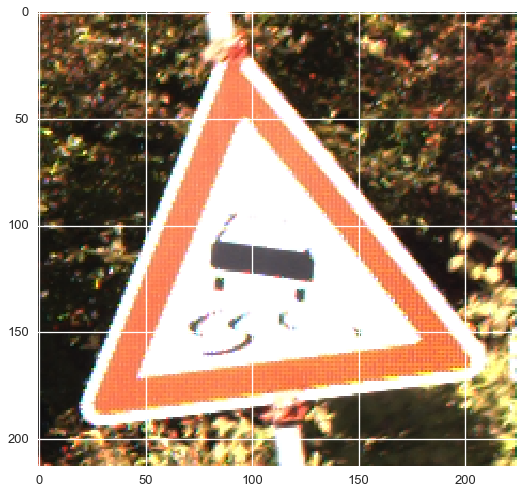

In [12]:
image = io.imread("train/27749.png")

io.imshow(image)

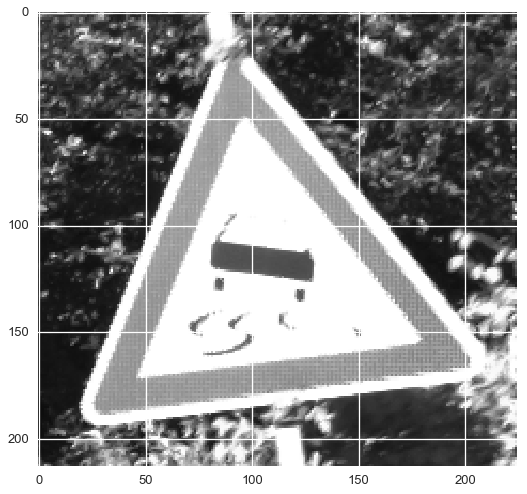

In [14]:
gray_image = rgb2gray(image)

io.imshow(gray_image)

In [15]:
gray_image.shape

(213, 226)

In [76]:
%%time
hog = extract_hog(gray_image)

abs
 [[ 0.33533652  0.02792993  0.13936748 ...,  0.04137335  0.79357554
   0.82655216]
 [ 0.06805188  0.29007268  0.18545605 ...,  0.21876477  0.80270675
   0.70393765]
 [ 0.39642492  0.25457286  0.18639093 ...,  0.34380906  0.61356813
   0.44803882]
 ..., 
 [ 0.34778164  0.09255537  0.02088418 ...,  0.47282554  0.78075641
   0.30256627]
 [ 0.29032959  0.18093829  0.11718175 ...,  0.47992203  0.32764691
   0.02601255]
 [ 0.20205217  0.163132    0.56331423 ...,  0.24751025  0.04961263
   0.03921373]]
theta
 [[  6.90829518e-01  -3.00472271e-03  -1.51091030e+00 ...,   2.98251809e+00
    1.42286540e+00   1.57079633e+00]
 [  3.02658834e+00  -2.40946740e+00  -2.53298877e+00 ...,   5.84644169e-01
    1.07975297e+00   1.57079633e+00]
 [  2.93223254e+00  -2.80266884e+00  -3.11970143e+00 ...,   1.37096741e+00
    1.38038197e+00   1.57079633e+00]
 ..., 
 [ -1.19992682e+00  -8.71841791e-01   1.48055975e+00 ...,   3.76631070e-01
    5.45739359e-01   1.57079633e+00]
 [ -1.26876333e+00  -9.63838827e-

In [74]:
hog.shape

(50544,)

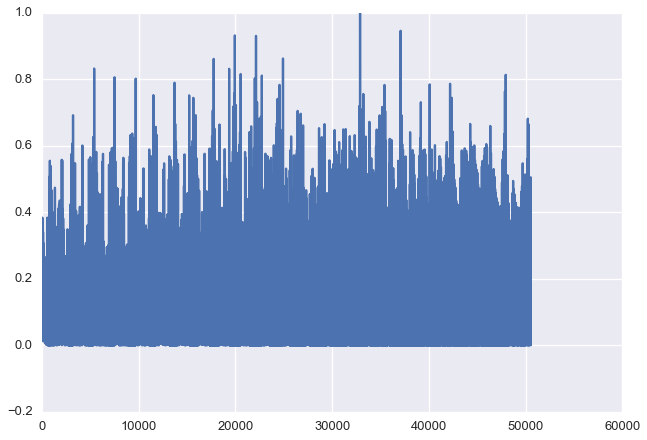

In [75]:
plt.plot(hog)

Протестируем на самом среднем изображении

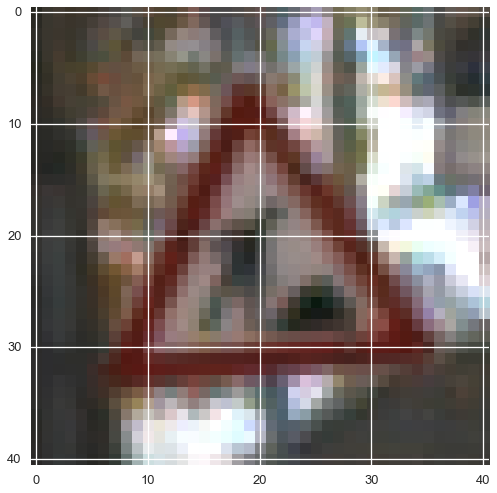

In [77]:
image = io.imread("train/28964.png")

io.imshow(image)

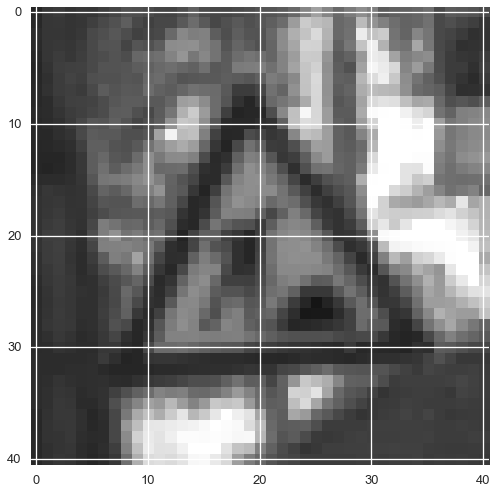

In [78]:
gray_image = rgb2gray(image)

io.imshow(gray_image)

In [79]:
gray_image.shape

(41, 41)

In [80]:
%%time
hog = extract_hog(gray_image)

abs
 [[ 0.05850907  0.01379714  0.00736611 ...,  0.09110146  0.13266639
   0.15759955]
 [ 0.03778841  0.00694852  0.01175423 ...,  0.08319798  0.11561803
   0.05933227]
 [ 0.05679953  0.02292628  0.0160743  ...,  0.10596774  0.05851694
   0.02699013]
 ..., 
 [ 0.05912705  0.02248066  0.025422   ...,  0.01604977  0.01228823
   0.02044822]
 [ 0.05291967  0.0243392   0.02974348 ...,  0.01121553  0.01688443
   0.00760618]
 [ 0.04928592  0.02234502  0.03809233 ...,  0.00814999  0.00670012
   0.02189121]]
theta
 [[  1.55655304e+00  -2.72159637e+00  -7.01691082e-01 ...,  -2.99872766e+00
   -2.64653175e+00  -2.67972109e+00]
 [  1.54874192e+00  -7.02015001e-01   9.90520258e-01 ...,  -2.36523364e+00
   -2.41593787e+00  -2.64098838e+00]
 [  1.57577430e+00  -6.49994777e-04   1.10198805e+00 ...,  -1.82716882e+00
   -1.88120240e+00   9.11102678e-01]
 ..., 
 [  1.55670192e+00   1.96703666e+00  -1.44901670e+00 ...,   2.81414255e-01
    1.82079937e-01  -7.16630777e-01]
 [  1.70875607e+00   1.77928004e+

In [81]:
hog.shape

(324,)

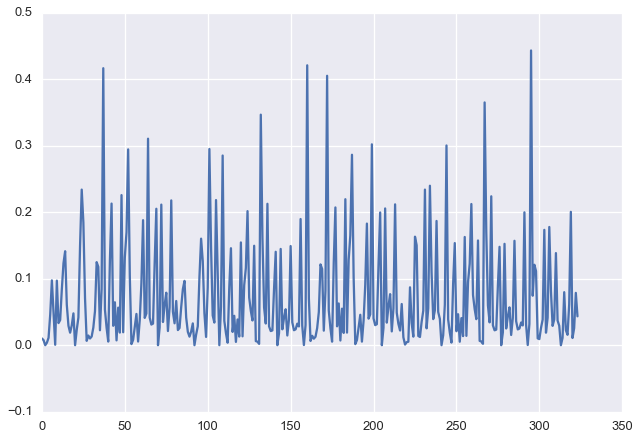

In [82]:
plt.plot(hog)

Протестируем на самом маленьком изображении

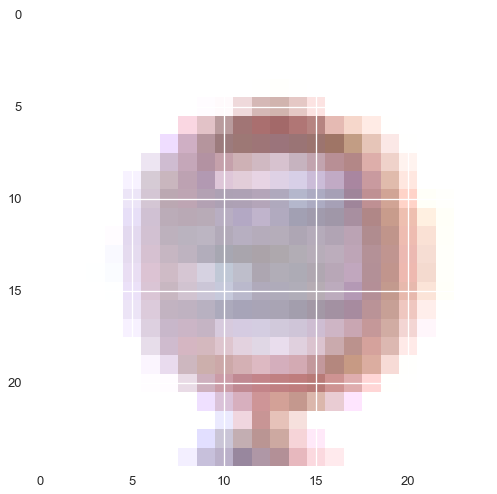

In [83]:
image = io.imread("train/02940.png")

io.imshow(image)

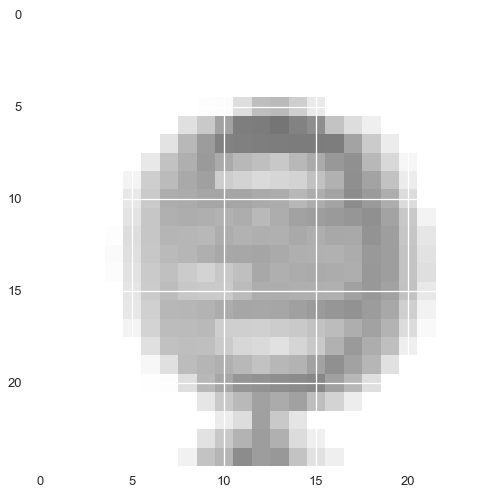

In [84]:
gray_image = rgb2gray(image)

io.imshow(gray_image)

In [87]:
gray_image.shape

(25, 25)

In [88]:
%%time
hog = extract_hog(gray_image, pixels_per_cell=(7, 7), cells_per_block=(2, 2))

abs
 [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.0000000

In [89]:
hog.shape

(144,)

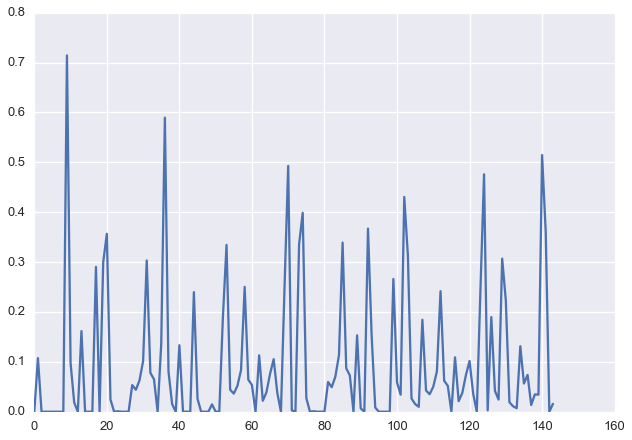

In [90]:
plt.plot(hog)

# Parameters

Приведём все картинки к размеру 42х42. Будем использовать ячейки 8х8 и блоки 3х3, 9 корзин в гистограмме.

Получим по 5х5 ячеек на картинку, 3х3 блока на картинку. Итого, получим 9 \* 9 \* 9 = 729 признаков

In [91]:
from skimage import transform

In [92]:
SHAPE = (42, 42)

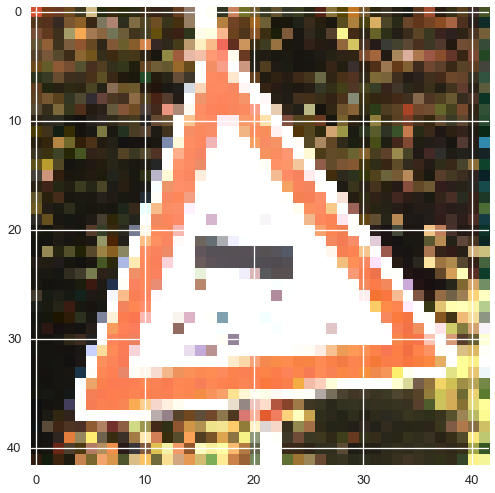

In [94]:
image = transform.resize(io.imread("train/27749.png"), SHAPE)

io.imshow(image)

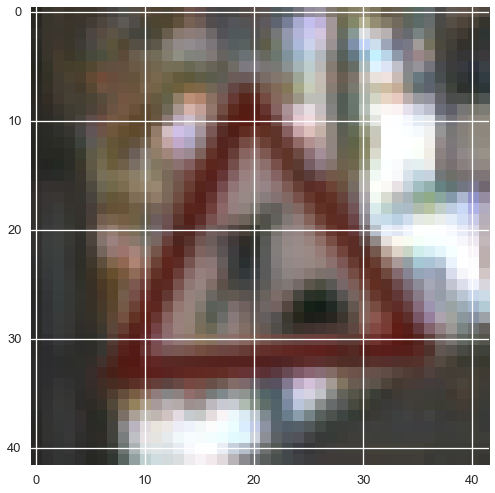

In [95]:
image = transform.resize(io.imread("train/28964.png"), SHAPE)

io.imshow(image)

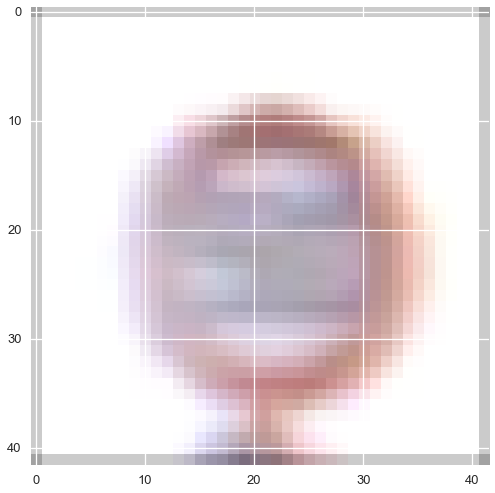

In [96]:
image = transform.resize(io.imread("train/02940.png"), SHAPE)

io.imshow(image)

In [97]:
DEBUG = False

In [98]:
gray_image = rgb2gray(image)

In [99]:
%%time
hog = extract_hog(gray_image)

CPU times: user 8.48 ms, sys: 1.54 ms, total: 10 ms
Wall time: 9.5 ms


In [100]:
hog.shape

(729,)

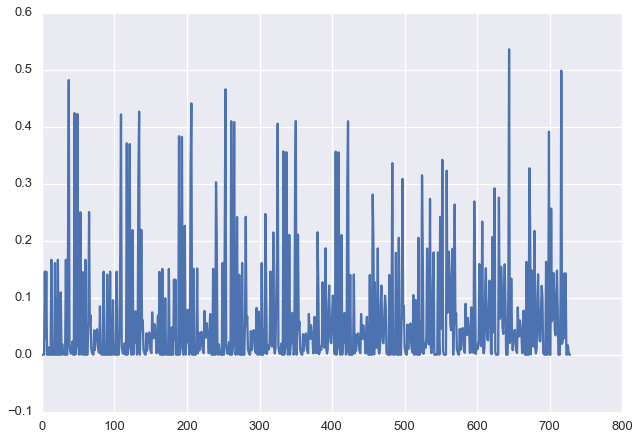

In [101]:
plt.plot(hog)

# Preprocessing

In [103]:
def image_to_vec(image, shape=SHAPE, **kwargs):
    image = rgb2gray(transform.resize(image, shape))
    return extract_hog(image, **kwargs)

In [107]:
def filename_to_vec(filename, prefix='train/', shape=SHAPE, **kwargs):
    return image_to_vec(io.imread(prefix + filename))

# Learning 

# Saving results